# Multi-cloudtype 
In this notebook, a model that will predict the mask for all four cloud types is looked at.  

In [1]:
import sys
sys.path.append('/Users/jack/git_repos/fastai_dev/dev')
from local.data.all import *
from local.vision.all import *
from local.vision.core import *
from local.vision.augment import *
from local.vision import models
from local.basics import *

## Data

In [2]:
CATS = ['fish', 'flower', 'gravel', 'sugar']

### Load the images' file paths and the annotations

In [3]:
SOURCE = Path('data/train_images/')

In [7]:
items = get_image_files(SOURCE)

In [8]:
items[11]

PosixPath('data/train_images/d5a17de.jpg')

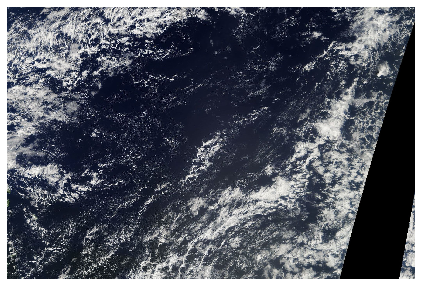

In [9]:
PILImage.create(items[11]).show(figsize=(10, 5));

In [10]:
IMG_SHAPE = PILImage.create(items[12]).shape
IMG_SHAPE

(1400, 2100)

In [11]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [12]:
annots = load_train_annotation('data/train.csv')

In [13]:
annots.head()

,Image,Label,EncodedPixels
0,0011165,fish,264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937 277518 937 278918 937 280318 937 281718 937 283118 937 284518 937 285918 937 287318 937 288718 937 290118 937 291518 937 292918 937 294318 937 295718 937 297118 937 298518 937 299918 937 301318 937 302718 937 304118 937 305518 937 306918 937 308318 937 309718 937 311118 937 312518 937 313918 937 315318 937 316718 937 318118 937 319518 937 320918 937 322318 937 323718 937 325118 937 326518 937 327918 937 329318 937 330718 937 332118 937 333518 937 334918 937 336318 937 337718 937 339118 937 34...
1,0011165,flower,1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1002 1366765 1002 1368165 1002 1369565 1002 1370965 1002 1372365 1002 1373765 1002 1375165 1002 1376565 1002 1377965 1002 1379365 1002 1380765 1002 1382165 1002 1383565 1002 1384965 1002 1386365 1002 1387765 1002 1389165 1002 1390565 1002 1391965 1002 1393365 1002 1394765 1002 1396165 1002 1397565 1002 1398965 1002 1400365 1002 1401765 1002 1403165 1002 1404565 1002 1405965 1002 1407365 1002 1408765 1002 1410165 1002 1411565 1002 1412965 1002 1414365 1002 1415765 1002 1417165 1002 1418565 100...
2,0011165,gravel,NaN
3,0011165,sugar,NaN
4,002be4f,fish,233813 878 235213 878 236613 878 238010 881 239410 881 240810 881 242210 881 243610 881 245010 881 246410 881 247810 881 249210 881 250610 881 252010 881 253410 881 254810 881 256210 881 257610 881 259010 881 260410 881 261810 881 263210 881 264610 881 266010 881 267410 881 268810 881 270210 881 271610 881 273010 881 274410 881 275810 881 277210 881 278610 881 280010 881 281410 881 282810 881 284210 881 285610 881 287010 881 288410 881 289810 881 291210 881 292610 881 294010 881 295410 881 296810 881 298210 881 299610 881 301010 881 302410 881 303810 881 305210 881 306610 881 308010 881 30...


### Rescaling the images
The original size of the images is 2100 px in width and 1400 px in height.  To start off with something smaller, a `Transform` is created for rescaling the images.  Here, the aspect ratio is kept the same, so no cropping or squishing.

In [14]:
class RescaleTfm(TupleTransform):
    def __init__(self, max_w=210, resample=Image.BILINEAR): 
        self.max_w, self.resample = max_w, resample
        
    def encodes(self, o:PILImage): return o.resize_max(max_w=self.max_w, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize_max(max_w=self.max_w, resample=Image.NEAREST)

In [15]:
SZ = 210

### Decode Run-length Encoding

In [16]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [17]:
class RLE_Decode(Transform):
    def __init__(self, cat, annots, img_shape): 
        self.cat, self.annots, self.img_shape = cat,  annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        px_rle = df[df.Label == self.cat].EncodedPixels.values[0]
        return rle_decode(px_rle, IMG_SHAPE)

In [18]:
annots[annots.Image == items[16].stem]

,Image,Label,EncodedPixels
8600,61d6640,fish,NaN
8601,61d6640,flower,NaN
8602,61d6640,gravel,1349079 387 1350479 387 1351879 387 1353279 387 1354679 387 1356079 387 1357479 387 1358879 387 1360279 387 1361679 387 1363079 387 1364479 387 1365879 387 1367279 387 1368679 387 1370079 387 1371479 387 1372879 387 1374279 387 1375679 387 1377079 387 1378479 387 1379879 387 1381279 387 1382679 387 1384079 387 1385479 387 1386879 387 1388279 387 1389679 387 1391079 387 1392479 387 1393879 387 1395279 387 1396679 387 1398079 387 1399479 387 1400879 387 1402279 387 1403679 387 1405079 387 1406479 387 1407879 387 1409279 387 1410679 387 1412079 387 1413479 387 1414879 387 1416279 387 1417679 ...
8603,61d6640,sugar,373839 334 375239 334 376639 334 378039 334 379439 334 380839 334 382239 334 383639 334 385039 334 386439 334 387839 334 389239 334 390639 334 392039 334 393439 334 394839 334 396239 334 397639 334 399039 334 400439 334 401839 334 403239 334 404639 334 406039 334 407439 334 408839 334 410239 334 411639 334 413039 334 414439 334 415839 334 417239 334 418639 334 420039 334 421439 334 422839 334 424239 334 425639 334 427039 334 428439 334 429839 334 431239 334 432639 334 434039 334 435439 334 436839 334 438239 334 439639 334 441039 334 442439 334 443839 334 445239 334 446639 334 448039 334 44...


In [19]:
for cat in CATS: print(cat, RLE_Decode(cat, annots, IMG_SHAPE)(items[16]).sum())

fish 0
flower 0
gravel 326241
sugar 1264697


### DataSource

In [20]:
def to_pilmask(o): return PILMask.create(o)

In [21]:
class Tensor2MaskTfm(TupleTransform):
    def encodes(self, o): return PILMask.create(o)

In [22]:
split_idx = RandomSplitter()(items)
tensor2mask = Tensor2MaskTfm()

tfms = [[PILImage.create], 
        [RLE_Decode('fish', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('flower', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('gravel', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('sugar', annots, IMG_SHAPE), tensor2mask]]

dsrc = DataSource(items, tfms=tfms, splits=split_idx, n_inp=1)

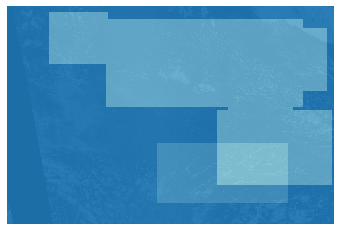

In [23]:
dsrc.show(dsrc[16]);

In [24]:
dsrc[16]

(<local.vision.core.PILImage image mode=RGB size=2100x1400 at 0x1A26785210>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A267859D0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A26780590>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A26778BD0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A26780E50>)

### DataBunch

In [25]:
rescale = RescaleTfm(max_w=SZ, resample=0)

In [26]:
rescale(dsrc[3])

(<local.vision.core.PILImage image mode=RGB size=210x140 at 0x1A26785850>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1A26785E50>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1A26785E10>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1A26785FD0>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1A267937D0>)

In [27]:
after_item_tfms = [rescale, ToTensor]

In [28]:
after_batch_tfms = [Cuda(), IntToFloatTensor()]

In [29]:
dbch = dsrc.databunch(after_item=after_item_tfms, after_batch=after_batch_tfms, bs=8)

In [30]:
xb, *yb = dbch.one_batch()

In [31]:
len(yb)

4

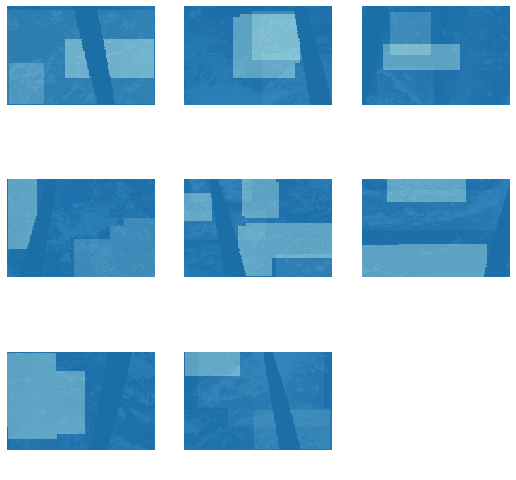

In [32]:
dbch.show_batch()

### Normalize

In [33]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [34]:
normalize = Normalize(*imagenet_stats)

Re-create `DataBunch`, adding `Normalize` transform:

In [35]:
after_item_tfms = [rescale, ToTensor]
after_batch_tfms = [Cuda(), IntToFloatTensor(), normalize]

In [36]:
dbch = dsrc.databunch(after_item=after_item_tfms, bs=4, after_batch=after_batch_tfms)

In [37]:
xb, *yb = dbch.one_batch()

In [38]:
xb.shape

torch.Size([4, 3, 140, 210])

In [39]:
for yb_ in yb: print(yb_.shape)

torch.Size([4, 140, 210])
torch.Size([4, 140, 210])
torch.Size([4, 140, 210])
torch.Size([4, 140, 210])


## Model


In [40]:
xb.shape, yb[0].shape, yb[1].shape, yb[2].shape

(torch.Size([4, 3, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]))

In [41]:
encoder = models.resnet34(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-2])

In [42]:
model = models.unet.DynamicUnet(encoder=encoder, n_classes=2, img_size=xb.shape[-2:], norm_type=None)


In [43]:
pred = model(xb)

In [44]:
pred.shape

torch.Size([4, 2, 140, 210])

In [45]:
model[-1][0].in_channels, model[-1][0].out_channels, model[-1][0].kernel_size

(99, 2, (1, 1))

In [46]:
model[-1]

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [47]:
ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [48]:
CATS

['fish', 'flower', 'gravel', 'sugar']

In [49]:
class CloudsCustomHead(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv_clouds = [ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None) for _ in CATS]
        self.conv_fish = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_flower = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_gravel = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_sugar = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
                
    def forward(self, o):
        #return tuple(m(o) for m in self.conv_clouds)
        return self.conv_fish(o), self.conv_flower(o), self.conv_gravel(o), self.conv_sugar(o)

In [50]:
custom_head = CloudsCustomHead()
custom_head

CloudsCustomHead(
  (conv_fish): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_flower): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_gravel): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_sugar): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [51]:
layers = list(model[:-1]) + [custom_head]

In [52]:
model = SequentialEx(*layers)

In [53]:
model

SequentialEx(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [54]:
y_test = model(xb)

In [55]:
y_test[0].shape, y_test[1].shape, y_test[2].shape, y_test[3].shape

(torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]))

In [56]:
yb[0].shape, yb[1].shape, yb[2].shape, yb[3].shape

(torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]))

## Loss Function

For the loss function the *cross entropy loss* is calculated for each of the four clouds types, and then they are summed.

In [57]:
y_test[0].shape, yb[0].shape

(torch.Size([4, 2, 140, 210]), torch.Size([4, 140, 210]))

In [58]:
CrossEntropyLossFlat(axis=1)(y_test[0], yb[0])

tensor(1.2340, grad_fn=<NllLossBackward>)

In [60]:
class CloudsLoss(CrossEntropyLossFlat):
    def __init__(self, *args, axis=1, **kwargs): super().__init__(*args, axis=1, **kwargs)
    def __call__(self, inp, *targ, **kwargs):
        assert len(inp) == len(targ)
        f = super().__call__
        return sum([f(i, t, **kwargs) for i, t in zip(inp, targ)])

In [61]:
CloudsLoss()(y_test, *yb)

tensor(2.2764, grad_fn=<AddBackward0>)

## Metrics

For the metric, the fraction of correctly classified pixels is shown for each cloud type.

In [62]:
def acc_seg(inp, *targ): 
    assert len(inp) == len(targ)
    return torch.stack([(i.argmax(dim=1) == t).float().mean() for i, t in zip(inp, targ)]).mean()

In [63]:
acc_seg(y_test, *yb)

tensor(0.7312)

## Learner

In [64]:
learn = Learner(dbch, model, loss_func=CloudsLoss(), opt_func=SGD, metrics=acc_seg)


In [65]:
learn.fit(n_epoch=1)

(#3) [0,2.7993762493133545,00:15]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

## Run-length encoding of masks

In [66]:
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

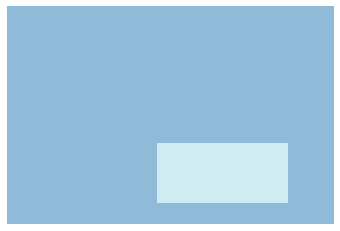

In [67]:
pilmask = dsrc[16][3]
pilmask.show()

In [68]:
mask_enc = mask2rle(tensor(pilmask))

In [71]:
type(mask_enc)

str

In [72]:
mask_dec = rle_decode(mask_enc, shape=pilmask.shape)

In [73]:
np.allclose(mask_dec, tensor(pilmask))

True

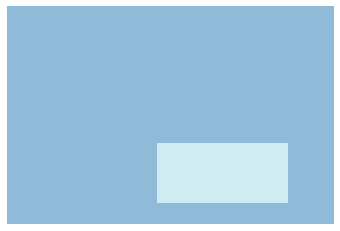

In [74]:
PILMask.create(mask_dec).show()

# - fin